In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


In [5]:
from keras.preprocessing.image import ImageDataGenerator

data_path="split-garbage-dataset"

train_datagen=ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
train_gen=train_datagen.flow_from_directory(data_path + '/train',
                                             target_size=(224,224),
                                             batch_size=64,
                                             class_mode='categorical')

val_datagen = ImageDataGenerator(rescale = 1./255)
val_gen=val_datagen.flow_from_directory(data_path + '/valid',
                                             target_size=(224,224),
                                             batch_size=1,
                                             class_mode='categorical',
                                             shuffle=False)

Found 2527 images belonging to 6 classes.
Found 328 images belonging to 6 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, preprocess_input

model = Sequential([ResNet101V2(include_top=False,
                             weights='imagenet',
                             pooling='avg'),
                    Dense(6, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')])
model.layers[0].trainable = False

In [7]:
opt=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)


In [8]:
model.compile(optimizer = opt,
              loss='squared_hinge',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 2048)              42626560  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 42,638,854
Trainable params: 12,294
Non-trainable params: 42,626,560
_________________________________________________________________


In [18]:
history = model.fit(x=train_gen,validation_data=val_gen,epochs=10)

Epoch 1/10
40/40 [==============================] - 521s 13s/step - loss: 1.0070 - accuracy: 0.8560 - val_loss: 0.9947 - val_accuracy: 0.8628
Epoch 2/10
40/40 [==============================] - 755s 19s/step - loss: 0.9969 - accuracy: 0.8647 - val_loss: 0.9865 - val_accuracy: 0.8689
Epoch 3/10
40/40 [==============================] - 369s 9s/step - loss: 0.9899 - accuracy: 0.8599 - val_loss: 0.9812 - val_accuracy: 0.8750
Epoch 4/10
40/40 [==============================] - 365s 9s/step - loss: 0.9833 - accuracy: 0.8678 - val_loss: 0.9733 - val_accuracy: 0.8720
Epoch 5/10
40/40 [==============================] - 531s 13s/step - loss: 0.9760 - accuracy: 0.8805 - val_loss: 0.9699 - val_accuracy: 0.8720
Epoch 6/10
40/40 [==============================] - 2492s 62s/step - loss: 0.9719 - accuracy: 0.8753 - val_loss: 0.9655 - val_accuracy: 0.8750
Epoch 7/10
40/40 [==============================] - 350s 9s/step - loss: 0.9678 - accuracy: 0.8805 - val_loss: 0.9550 - val_accuracy: 0.9055
Epoch 8/

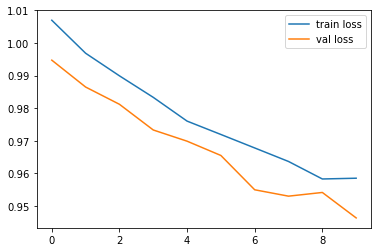

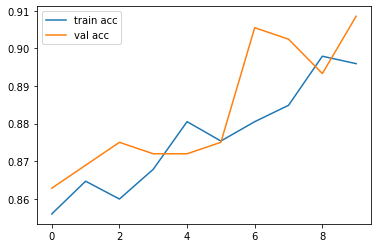

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
model.save('resnet101V2.h5')

In [21]:
from tensorflow.keras.models import load_model
model=load_model('resnet101V2.h5')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 2048)              42626560  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 42,638,854
Trainable params: 12,294
Non-trainable params: 42,626,560
_________________________________________________________________


In [22]:
data_path ="split-garbage-dataset"

test_datagen= ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(data_path + '/test',
                                              target_size=(224,224),
                                              batch_size=1,
                                              class_mode='categorical',
                                              shuffle=False)


Found 431 images belonging to 6 classes.


In [23]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)


Text(0.5, 1.0, 'Confusion matrix of model')

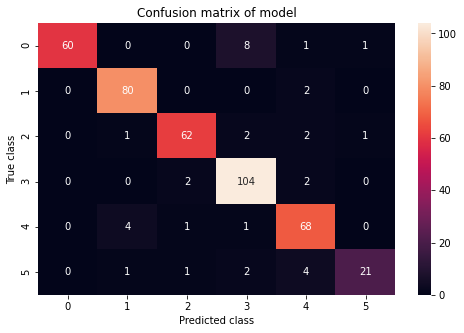

In [24]:
from sklearn.metrics import confusion_matrix,accuracy_score
cf_matrix = confusion_matrix(test_gen.classes, y_pred)
import seaborn as sns
plt.figure(figsize=(8,5))
heatmap = sns.heatmap(cf_matrix, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

In [25]:
accuracy_score(test_gen.classes, y_pred)


0.9164733178654292